In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import sklearn
from sklearn.model_selection import train_test_split
from itertools import permutations 
from scipy import stats
import random
from sklearn.metrics import confusion_matrix
from PIL import Image
import os, sys
from skimage.io import imread_collection

KeyError: <class 'bool'>

In [13]:
def resize(path, path_new):
    dirs = os.listdir( path )
    i = 0
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
            imResize.save(path_new + str(i) + '.jpg', 'JPEG', quality=100)
            i += 1

In [83]:
def partition(A):
    matr = []
    for i in range(8):
        for j in range(8):
            a = i*32
            b = j*32
            matr.append(A[a:a+32,b:b+32])
    return matr

In [85]:
def binRepresentation(image):
    
    bins = [0,32,64,96,128,160,192,224,256,288]
    im = image.reshape(3,256,256)
    res = np.zeros((64,1))
    
    for i in range(3):
        
        matrices = partition(im[i])
        EachColor = np.zeros(8)
        for j in range(len(matrices)):
            
            p = matrices[j].reshape(1,32*32)[0]
            bin_indices = np.digitize(p, bins)
            sr = pd.Series(bin_indices)
            sr = sr.value_counts()
            d = np.zeros(8)
            for k in range(8):
                try:
                    d[k] = sr[k+1]
                except:
                    'EOF'
            EachColor = np.vstack((EachColor, d))
        
        EachColor = EachColor[1:,:]
    
        res = np.hstack((res,EachColor))
        
    return res[:,1:]

In [90]:
def AllClassesBinRepresentation(data):
    
    k = len(data)
    
    for i in range(k):
        
        for j in range(len(data[i])):
            
            if(j == 0):
                eachImage = binRepresentation(data[i][j])
            else:
                eachImage = np.vstack((eachImage, binRepresentation(data[i][j])))
                
        if(i == 0):
            res = eachImage
        else:
            res = np.vstack((res, eachImage))
            
    return res

In [118]:
f1 = 'Dataset/Classification/Image_Group17/train/formal_garden/'
f2 = 'Dataset/Classification/Image_Group17/train/engine_room/'
f3 = 'Dataset/Classification/Image_Group17/train/basement/'

f1_new = 'Dataset/Classification/Image_Group17/train/formal_garden_resized/'
f2_new = 'Dataset/Classification/Image_Group17/train/engine_room_resized/'
f3_new = 'Dataset/Classification/Image_Group17/train/basement_resized/'

In [14]:
resize(f1, f1_new)
resize(f2, f2_new)
resize(f3, f3_new)

In [15]:
ext = "*.jpg"
classes = [0]*3
classes[0] = imread_collection(f1_new+ext)
classes[1] = imread_collection(f2_new+ext)
classes[2] = imread_collection(f3_new+ext)

In [88]:
dfTrain = AllClassesBinRepresentation(classes)

In [89]:
dfTrain.shape

(9600, 24)

In [91]:
f1_test = 'Dataset/Classification/Image_Group17/test/formal_garden/'
f2_test = 'Dataset/Classification/Image_Group17/test/engine_room/'
f3_test = 'Dataset/Classification/Image_Group17/test/basement/'

f1_test_new = 'Dataset/Classification/Image_Group17/test/formal_garden_resized/'
f2_test_new = 'Dataset/Classification/Image_Group17/test/engine_room_resized/'
f3_test_new = 'Dataset/Classification/Image_Group17/test/basement_resized/'

In [92]:
resize(f1_test, f1_test_new)
resize(f2_test, f2_test_new)
resize(f3_test, f3_test_new)

In [93]:
ext = "*.jpg"
classesTest = [0]*3
classesTest[0] = imread_collection(f1_test_new+ext)
classesTest[1] = imread_collection(f2_test_new+ext)
classesTest[2] = imread_collection(f3_test_new+ext)

In [94]:
dfTest = AllClassesBinRepresentation(classesTest)

In [95]:
dfTest.shape

(9600, 24)

In [96]:
dataset = np.vstack((dfTrain, dfTest))

In [97]:
dataset.shape

(19200, 24)

In [99]:
from sklearn.cluster import KMeans

In [100]:
kmeans = KMeans(n_clusters=32, random_state=0).fit(dataset)

In [104]:
len(kmeans.labels_)

19200

In [107]:
def labelRepresentation(image, kmeans):
    
    im = image.reshape(3,256,256)
    vec = binRepresentation(im)
    preds = kmeans.predict(vec)
    sr = pd.Series(preds)
    sr = sr.value_counts()
    d = np.zeros(32)
    
    for k in range(32):
        try:
            d[k] = sr[k]
        except:
            'EOF'
    
    return d

In [111]:
def AllImagesBoVWRepresentation(data, kmeans):
    
    k = len(data)
    res = []
    for i in range(k):
        
        for j in range(len(data[i])):
            
            if(j == 0):
                eachImage = labelRepresentation(data[i][j], kmeans)
            else:
                eachImage = np.vstack((eachImage, labelRepresentation(data[i][j], kmeans)))
                
        res.append(eachImage)
            
    return res

In [112]:
BoVWTrain = AllImagesBoVWRepresentation(classes, kmeans)

In [117]:
BoVWTest = AllImagesBoVWRepresentation(classesTest, kmeans)

In [120]:
np.sum(BoVWTest[0] == BoVWTrain[0])

937

In [124]:
np.sum(BoVWTest[0] == BoVWTrain[1])

854

In [125]:
np.sum(BoVWTest[0] == BoVWTrain[2])

909

In [126]:
np.sum(BoVWTest[1] == BoVWTrain[1])

788

In [127]:
np.sum(BoVWTest[1] == BoVWTrain[0])

865

In [128]:
np.sum(BoVWTest[1] == BoVWTrain[2])

855

In [129]:
np.sum(BoVWTest[2] == BoVWTrain[2])

952

In [130]:
np.sum(BoVWTest[2] == BoVWTrain[0])

945

In [131]:
np.sum(BoVWTest[2] == BoVWTrain[1])

838

# Some Experimentation

In [141]:
MeanBoVWTrain_formal_garden = np.sum(BoVWTrain[0],axis = 0)/50

In [147]:
MeanBoVWTest_formal_garden = np.sum(BoVWTest[0], axis = 0)/50

In [150]:
MeanBoVWTrain_engine_room = np.sum(BoVWTrain[1],axis = 0)/50

In [151]:
MeanBoVWTest_engine_room = np.sum(BoVWTest[1],axis = 0)/50

In [152]:
MeanBoVWTrain_basement = np.sum(BoVWTrain[2],axis = 0)/50

In [153]:
MeanBoVWTest_basement = np.sum(BoVWTest[2],axis = 0)/50

## Comparing Formal Garden Test Images (Mean) with all three Train Images BoVW Representation (Mean)

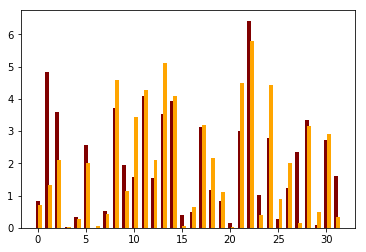

In [149]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.title()
plt.bar(xlabels, MeanBoVWTrain_formal_garden, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)


plt.show()

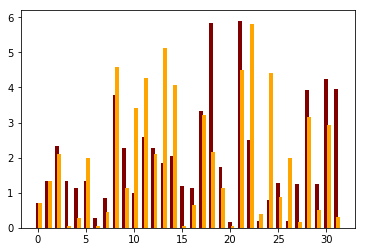

In [156]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.bar(xlabels, MeanBoVWTrain_engine_room, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)

plt.show()

In [1]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.bar(xlabels, MeanBoVWTrain_basement, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)
plt.label()

plt.show()

NameError: name 'plt' is not defined